In [1]:
import numpy as np
import matplotlib.pyplot as plt
from hcipy import *
from hcipy.optics.detector import NoisyDetector
from hcipy.mode_basis.zernike import make_zernike_basis
from hcipy.atmosphere import *
from imageio import get_writer
from tqdm import tqdm
import pickle
# import mymethods

In [264]:
#mymethods
import numpy as np
from hcipy.util import large_poisson
from hcipy.field import subsample_field, make_supersampled_grid
from hcipy.atmosphere.infinite_atmospheric_layer import InfiniteAtmosphericLayer
from hcipy.mode_basis.zernike import make_zernike_basis
from hcipy.atmosphere.modal_adaptive_optics_layer import ModalAdaptiveOpticsLayer

class Detector(object):
    '''Base class for a detector.

    Parameters
    ----------
    detector_grid : Grid
        The grid on which the detector returns its images. These indicate
        the centers of the pixels.
    subsamping : integer or scalar or ndarray
        The number of subpixels per pixel along one axis. For example, a
        value of 2 indicates that 2x2=4 subpixels are used per pixel. If
        this is a scalar, it will be rounded to the nearest integer. If
        this is an array, the subsampling factor will be different for
        each dimension. Default: 1.

    Attributes
    ----------
    input_grid : Grid
        The grid that is expected as input.
    '''
    def __init__(self, detector_grid, subsamping=1):
        self.detector_grid = detector_grid
        self.subsamping = subsamping

        if subsamping > 1:
            self.input_grid = make_supersampled_grid(detector_grid, subsamping)
        else:
            self.input_grid = detector_grid

    def integrate(self, wavefront, dt, weight=1):
        '''Integrates the detector.

        Parameters
        ----------
        wavefront : Wavefront or array_like
            The wavefront sets the amount of power generated per unit time.
        dt : scalar
            The integration time in units of time.
        weight : scalar
            Weight of every unit of integration time.
        '''
        raise NotImplementedError()

    def read_out(self):
        '''Reads out the detector.

        No noise will be added to the image.

        Returns
        -------
        Field
            The final detector image.
        '''
        raise NotImplementedError()

    def __call__(self, wavefront, dt=1, weight=1):
        '''Integrate and read out the detector.

        This is a convenience function to avoid having to call two functions
        in quick succession.

        Parameters
        ----------
        wavefront : Wavefront or array_like
            The wavefront sets the amount of power generated per unit time.
        dt : scalar
            The integration time in units of time.
        weight : scalar
            Weight of every unit of integration time.

        Returns
        -------
        Field
            The final detector image.
        '''
        self.integrate(wavefront, dt, weight)
        return self.read_out()
    
class NoisyDetector(Detector):

    '''A detector class that has some basic noise properties.

    A detector that includes the following noise sources: photon shot noise, dark current
    shot noise, flat field errors and read noise. These noise sources (except for photon shot
    noise) can be either a scalar (same for entire grid) or an array. For the flat field error
    specifically: if a scalar is given, a normal distributed flat field map (given scalar
    is standard deviation about 1) is generated that will be used - if an array is given, that
    array will be used, so it will NOT be a normal distributed flat field where every point in
    array gives the standard deviation. This allows the user to load a specific flat field map.

    The detector can also integrate supersampled wavefronts and subsample them to the correct
    grid size. This allows for the averaging of the power over one detector pixel.

    Parameters
    ----------
    detector_grid : Grid
        The grid on which the detector samples.
    dark_current_rate : scalar or array_like
        An array or scalar that gives dark current rate in counts per unit time for each point
        in the grid.
    read_noise : scalar or array_like
        An array or scalar that gives the rms read noise counts for each point in the grid.
    flat_field : scalar or array_like
        An array or scalar that gives the flat field error for each point in the
        grid. If a scalar is given, a random normal distributed flat field map (given scalar
        is standard deviation about 1) is generated that will be used.
    include_photon_noise : boolean
        Turns the photon noise on or off. Default: True.
    subsampling : integer or scalar or ndarray
        The number of subpixels per pixel along one axis. For example, a
        value of 2 indicates that 2x2=4 subpixels are used per pixel. If
        this is a scalar, it will be rounded to the nearest integer. If
        this is an array, the subsampling factor will be different for
        each dimension. Default: 1.
    '''
    def __init__(self, detector_grid, dark_current_rate=0, read_noise=0, flat_field=0, include_photon_noise=True, subsampling=1):
        Detector.__init__(self, detector_grid, subsampling)

        # Setting the start charge level.
        self.accumulated_charge = 0

        # The parameters.
        self.dark_current_rate = dark_current_rate
        self.read_noise = read_noise
        self.flat_field = flat_field
        self.include_photon_noise = include_photon_noise

    @property
    def flat_field(self):
        return self._flat_field

    @flat_field.setter
    def flat_field(self, flat_field):
        # If the flatfield parameters was a scalar, we will generate a flat field map that will
        # be constant for this object until flat_field is manually changed.
        if np.isscalar(flat_field):
            self._flat_field = np.random.normal(loc=1.0, scale=flat_field, size=self.detector_grid.size)
        else:
            self._flat_field = flat_field
        
    def integrate(self, wavefront, dt, weight=1):
        '''Integrates the detector.

        The amount of power and dark current that the detector generates are calculated
        for a given integration time and weight.

        Parameters
        ----------
        wavefront : Wavefront or array_like
            The wavefront sets the amount of power generated per unit time.
        dt : scalar
            The integration time in units of time.
        weight : scalar
            Weight of every unit of integration time.
        '''
        # The power that the detector detects during the integration.
        if hasattr(wavefront, 'power'):
            power = wavefront.power
        else:
            power = wavefront

        self.accumulated_charge += subsample_field(power, subsampling=self.subsamping,
                                                    new_grid=self.detector_grid, statistic='sum') * dt * weight

        # Adding the generated dark current.
        self.accumulated_charge += self.dark_current_rate * dt * weight

    def read_out(self, final_frame=True):
        '''Reads out the detector.

        The read out operation of the detector. This means that, if applicable, first photon noise
        will be included to the power. Then, in this order, the flat field error and
        read-out noise are applied. After the read out the power is reset.

        Returns
        -------
        Field
            The final detector image.
        '''
        # Make sure not to overwrite output
        output_field = self.accumulated_charge.copy()

        if final_frame:
            # Adding photon noise.
            if self.include_photon_noise:
                output_field = large_poisson(output_field, thresh=1e6)

            # Adding flat field errors.
            output_field *= self.flat_field

            # Adding read-out noise.
            output_field += np.random.normal(loc=0, scale=self.read_noise, size=output_field.size)

            # Reset detector
            self.accumulated_charge = 0
            
        return output_field
    
class Frame_Generator():
    """A class to generate frames for a given time t."""
    def __init__(self, detector, star_power, prop, strehl_ref):
        self.detector = detector
        self.star_power = star_power
        self.prop = prop
        self.strehl_ref = strehl_ref

    def generate_frame(self, t, wf, aperture, atmosphere, pupil_wavefront, reset_time = 0.1, integration_time = 0.001):
        """Generate and save a frame for the given time t."""
        
        atmosphere.evolve_until(t) # Evolve the atmosphere to the current time t
        wf2 = atmosphere.forward(wf) # Propagate the wavefront through the atmosphere
        wf3 = wf2.copy() # Copy the wavefront
        wf3.electric_field = (wf2.electric_field * aperture) * pupil_wavefront.electric_field # Apply the aperture and pupil(mirror) wavefront
        wf3.total_power = self.star_power # Set the total power of the wavefront to the star power
        focal_wf = self.prop(wf3) # Propagate the wavefront to the focal plane
        self.detector.integrate(focal_wf, integration_time) # Integrate the wavefront on the detector

        if t % reset_time < 0.0001:
            img = self.detector.read_out(final_frame = True)
            
        else:
            img = self.detector.read_out(final_frame = False)
        
        psf_m = img.copy()
        mat_size = int(np.sqrt(psf_m.shape[0]))
        im = psf_m.reshape((mat_size, mat_size)).T
        strehl = get_strehl_from_focal(psf_m, self.strehl_ref)
        val, _, _ = cost(im, plot=False)
        
        
        return wf2.phase, wf3.phase, img, float(val), float(strehl)
        
def make_keck_atmospheric_layers(input_grid, d=0.6, num_modes=6, starting_mode=4, seed=11):
    '''Creates a multi-layer atmosphere for Keck Observatory.

    The atmospheric parameters are based off of [Keck AO note 303]_.

    .. [Keck AO note 303] https://www2.keck.hawaii.edu/optics/kpao/files/KAON/KAON303.pdf

    Parameters
    ----------
    input_grid : Grid
        The input grid of the atmospheric layers.

    Returns
    -------
    list
        A list of turbulence layers.
    '''
    heights = np.array([0, 2100, 4100, 6500, 9000, 12000, 14800])
    velocities = np.array([6.7, 13.9, 20.8, 29.0, 29.0, 29.0, 29.0])
    outer_scales = np.array([20, 20, 20, 20, 20, 20, 20])
    Cn_squared = np.array([0.369, 0.219, 0.127, 0.101, 0.046, 0.111, 0.027]) * 1e-12

    layers = []
    mode_basis = make_zernike_basis(num_modes=num_modes, D=d, grid=input_grid, starting_mode=starting_mode)
    for h, v, cn, L0 in zip(heights, velocities, Cn_squared, outer_scales):
        
        layers.append(ModalAdaptiveOpticsLayer(InfiniteAtmosphericLayer(input_grid, cn, L0, v, h, 2, seed=seed), mode_basis, 1))
        print("Added layer at height {}m with Cn^2 = {} m^-2/3, L0 = {}m, and v = {}m/s".format(h, cn, L0, v))
    return layers

def cost_function(im, wave=590e-9, bound=0, plot=False, show=False):
    # Ignore pixels below 50, needed to combat noise    
    if np.average(im) < 2:
        #im[im < bound] = 0
        set_center = True
    else:
        set_center = False
    # if im.max() == 0.0:
    #     raise Exception('All values are zero!')
    
    x_arr = np.arange(im.shape[0], dtype=float)
    y_arr = np.arange(im.shape[1], dtype=float)
    
    tot = im.sum()
    
    y_cm = im.sum(axis=0).dot(y_arr)/tot
    x_cm = im.sum(axis=1).dot(x_arr)/tot
    
    if x_cm > im.shape[0] or set_center:
        x_cm = im.shape[0]/2
        out_of_bounds_x = True
    if y_cm > im.shape[1] or set_center:
        y_cm = im.shape[1]/2
        out_of_bounds_y = True

    # Shift position arrays to center mass point
    x_arr -= x_cm
    y_arr -= y_cm
    
    # Square
    x_arr *= x_arr
    y_arr *= y_arr
    
    # Radial distance squared
    r2 = x_arr[:,None]+y_arr
    
    # Moment of intertia
    moi = (r2 * im).sum()

    c = moi/im.sum()
    
    # Draw on figure (used only for debug!)
    if plot:
        
        intensity = im.max()
        im[:,int(y_cm)] = intensity
        im[int(x_cm),:] = intensity
        
        # Equivalent radius of fully filled in circle
        if out_of_bounds_x or out_of_bounds_y or moi < 0:
            r = (im.shape[0]/2)
            offset = (im.shape[0]/2)
        else:
            r = (moi * 4/np.pi)**0.25/4
            offset = int(r*3)

        

        x1 = int(x_cm - r)+1
        x2 = int(x_cm + r)-1
        y1 = int(y_cm - r)+1
        y2 = int(y_cm + r)-1
        
        x_l_lim = y_cm-offset
        x_u_lim = y_cm+offset
        y_u_lim = x_cm+offset
        y_l_lim = x_cm-offset

        # if not (0 < x1 < im.shape[0] or 0 < x2 < im.shape[0] or
        #         0 < y1 < im.shape[1] or 0 < y2 < im.shape[1]):
        #     raise Exception('Out of bounds! Lights are on!')
        
        im[x1,y1:y2] = intensity
        im[x2,y1:y2] = intensity
        im[x1:x2,y1] = intensity
        im[x1:x2,y2] = intensity
         
        # plt.figure(num=2, dpi=500)
        # plt.imshow(im, cmap='viridis')
        # # plt.pcolormesh(im, shading='auto', cmap='viridis')
        # plt.xlim([x_l_lim, x_u_lim])
        # plt.ylim([y_u_lim, y_l_lim]) # for some reason the plot pf just the PSF is inverted in Y axis thus it reuquires bound inversion to keep the psf in the same orientation
        # plt.title(f'Cost_value: {c:.0f}')
        # plt.colorbar()
        # plt.gca().set_aspect('equal')
        # plt.show()
        # plt.clf()
        
        x = np.linspace(-1, 1, np.shape(im)[0])
        y = np.linspace(1, -1, np.shape(im)[1])
        X, Y = np.meshgrid(x, y)
        formatted_wave = '{:.5f}'.format(c)
        
        fig, ax = plt.subplots(num=3, dpi=500)
        im_psf = plt.pcolormesh(X, Y, im, shading='auto', cmap='viridis')
        ax.set_title('PSF value {}'.format(formatted_wave))
        ax.set_aspect('equal')
        plt.colorbar(im_psf, ax=ax)
        if show == True:
            plt.show()
        fig.clear()

    return c, x_cm, y_cm #, im, X, Y

def error(wf, init_wf=0):

    rms = np.sqrt(np.mean(np.square(wf)))
    rms_init = np.sqrt(np.mean(np.square(init_wf)))
    
    pv_wf = np.max(wf) - np.min(wf)
    pv_wf_init = np.max(init_wf) - np.min(init_wf)
    
    #impr_rms = (rms_init / rms) * 100
    
    return rms, pv_wf, pv_wf_init, rms_init

class History():
    
    def __init__(self): 
        self.cost_history = []
        self.rms_impr_hist = np.empty((0))
        self.pv_impr_hist = np.empty((0))
        self.pv_hist = np.empty((0))
        self.init_pv_hist = np.empty((0))
        self.opt_time_hist = []
        self.rms_init_hist = np.empty((0))
    
    def __enter__(self):
        return self
    
    def __exit__(self, exc_type, exc_value, traceback):
        print("Exiting the History")
        if exc_type is not None:
            print(f"Exception occurred: {exc_type.__name__}: {exc_value}")
        return self.cost_history, self.rms_impr_hist, self.pv_impr_hist, self.init_pv_hist, self.pv_hist, self.opt_time_hist
            
    def record_hist(self, init_wf, wavefront, cost_hist_run, opt_time):    
        
        rms_impr, pv_wf, init_wf_pv, rms_init = error(wavefront, init_wf)
        
        self.cost_history.append(cost_hist_run)
        self.rms_impr_hist = np.append(self.rms_impr_hist, rms_impr)
        self.init_pv_hist = np.append(self.init_pv_hist, init_wf_pv)
        self.pv_hist = np.append(self.pv_hist, pv_wf)
        self.opt_time_hist.append(opt_time)
        self.rms_init_hist = np.append(self.rms_init_hist, rms_init)

def get_star_power(luminosity = 87100, distance_to_star=600, relative_magnitude=-4):
    
    permitivity = 8.854187817e-12 #F/m
    c = 299792458 #m/s
    diameter_t = 2.2 # m
    sun_luminosity = 3.828e26 #W
    distance = distance_to_star * 9.461e15 #m
    area = np.pi*(diameter_t/2)**2 #m^2
    # star_luminosity = sun_luminosity * luminosity #W
    # star_flux_density = star_luminosity/(4*np.pi*distance**2) #W/m^2
    # electric_field = star_flux_density*(2/(permitivity*c))
    # el_power_at_pupil = electric_field * area 

    jan_convertion = 1.51e7 # Photons/(s m^2) (dlambda/lambda) 
    dlam_lam = 0.16 # delta lambda / lambda for V band per 1 square meter aperture (1/m^2)
    flux_m0_V = 3640 # Janskys at V band - 550nm 
    delta_m = relative_magnitude
    scale = 10**(-0.4*delta_m)
    flux_m = flux_m0_V * scale # Janskys
    N_p = flux_m * jan_convertion * dlam_lam # Photons/(s m^2)
    N_p_um = N_p / 1e12 # Photons/(s um^2) 
   
    plank_const = 6.62607015e-34 # Joule seconds
    lambda_m = 590e-9 # m
    freq = c / lambda_m # Hz
    intensity = N_p * plank_const * freq # W/m^2
    electric_field_power = ((intensity * 2)/(permitivity*c))
    return electric_field_power * area * 1e7 # W

In [211]:
# Wavefronts
N = 801 #Resolution of the grid.
d = 0.6 #Diameter of the aperture.
wavelength = 590e-9 # meters. Wavelength of the light.
luminosity = 87100 #W/m^2. Intensity of the light times the luminosity of the sun
coeficients_flat = [0, 0, 0, 0, 0, 0, 0, 0] #flat wavefront.
coeficients_atmo = [600e-9, 0, 0, 0, 1000e-9, 0]#, 0, 0] #tilted wavefront.
coeficients = [0, 0, 0, 3200e-9, 2000e-9, 1200e-9, 600e-9, 300e-9]

#Defining the grids.
pupil_grid = make_pupil_grid(N)
aperture = make_circular_aperture(d)(pupil_grid)

#The wavefront in the pupil.
zern = make_zernike_basis(8, d, pupil_grid, starting_mode=1, ansi=False, radial_cutoff=True, use_cache=True)
full_wf = zern.linear_combination(coeficients)
pupil_wavefront = Wavefront(np.exp(1j*((2*np.pi)/590e-9)*full_wf)*aperture, wavelength=590e-9)

zern_flat = make_zernike_basis(8, d, pupil_grid, starting_mode=1, ansi=False, radial_cutoff=True, use_cache=True)
full_wf_flat = zern_flat.linear_combination(coeficients_flat)
pupil_wavefront_flat = Wavefront(np.exp(1j*((2*np.pi)/590e-9)*full_wf_flat)*aperture, wavelength=590e-9)

zern_atmo = make_zernike_basis(6, d, pupil_grid, starting_mode=4, ansi=False, radial_cutoff=True, use_cache=True)
full_wf_atmo = zern_atmo.linear_combination(coeficients_atmo)
pupil_wavefront_atmo = Wavefront(np.exp(1j*((2*np.pi)/590e-9)*full_wf_atmo)*aperture, wavelength=590e-9)

pupil_wavefront_flat.total_power = get_star_power()
pupil_wavefront.total_power = get_star_power() 
# print(pupil_wavefront.total_power)


In [380]:
focal_grid = make_focal_grid_from_pupil_grid(pupil_grid, num_airy=50)
focal_grid = focal_grid.scaled(wavelength)
prop = FraunhoferPropagator(aperture.grid, focal_grid, focal_length=1)
# np.random.seed(11)
number_of_modes = 20
random_vect = np.random.uniform(-1, 1, number_of_modes)
zern = make_zernike_basis(number_of_modes, d, pupil_grid, starting_mode=1, ansi=False, radial_cutoff=True, use_cache=True)
full_wf = zern.linear_combination(random_vect)
rms = np.sqrt(np.mean(np.square(full_wf)))
pv_wf = np.max(full_wf) - np.min(full_wf)
print(full_wf[320800])
print("rms is:",rms, "pv is:",pv_wf)
imshow_field(full_wf.phase, cmap='RdBu')
plt.colorbar()
plt.show()


c:\Users\papuckaj\OneDrive - TNO\Desktop\MASTER\GitHub\AO_model\.venv\Lib\site-packages\hcipy\mode_basis\zernike.py:138: RuntimeWarning: divide by zero encountered in divide
  res = h1 * zernike_radial(p, q, r, cache) + (h2 + h3 / r2) * zernike_radial(n, q - 2, r, cache)
c:\Users\papuckaj\OneDrive - TNO\Desktop\MASTER\GitHub\AO_model\.venv\Lib\site-packages\hcipy\mode_basis\zernike.py:138: RuntimeWarning: invalid value encountered in multiply
  res = h1 * zernike_radial(p, q, r, cache) + (h2 + h3 / r2) * zernike_radial(n, q - 2, r, cache)


nan
rms is: nan pv is: nan


AttributeError: 'OldStyleField' object has no attribute 'phase'

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
rms is: nan pv is: nan


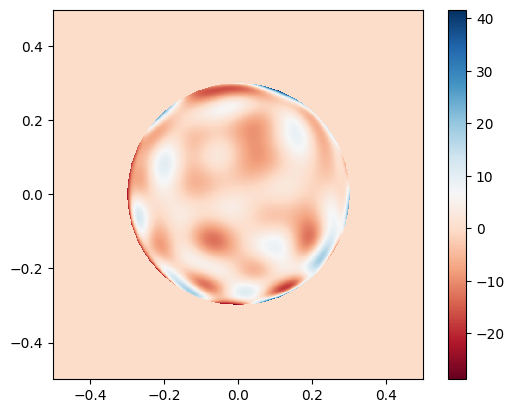

Cost is: nan
rms is: nan


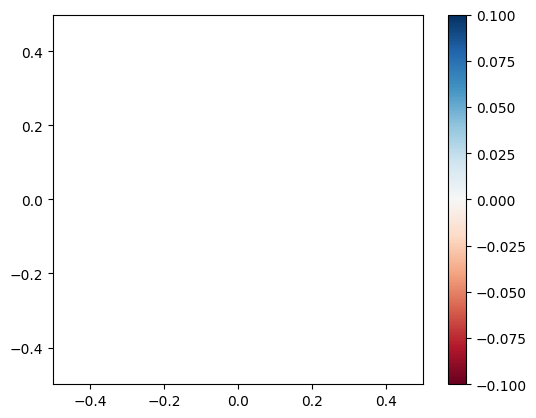

In [295]:
focal_grid = make_focal_grid_from_pupil_grid(pupil_grid, num_airy=50)
focal_grid = focal_grid.scaled(wavelength)
prop = FraunhoferPropagator(aperture.grid, focal_grid, focal_length=1)
# np.random.seed(11)
number_of_modes = 100
random_vect = np.random.uniform(-1, 1, number_of_modes)
zern = make_zernike_basis(number_of_modes, d, pupil_grid, starting_mode=1, ansi=False, radial_cutoff=True, use_cache=True)
full_wf = zern.linear_combination(random_vect)
rms = np.sqrt(np.mean(np.square(full_wf)))
pv_wf = np.max(full_wf) - np.min(full_wf)
print(full_wf[0:99])
print("rms is:",rms, "pv is:",pv_wf)
imshow_field(full_wf, cmap='RdBu')
plt.colorbar()
plt.show()

max_error = 12000e-9
scale = max_error / pv_wf
zero_vector = random_vect*scale
zern = make_zernike_basis(number_of_modes, d, pupil_grid, starting_mode=1, ansi=False, radial_cutoff=True, use_cache=True)
full_wf = zern.linear_combination(zero_vector)
pupil_wavefront = Wavefront(np.exp(1j*((2*np.pi)/590e-9)*full_wf)*aperture, wavelength=590e-9)
focal_wavefront = prop.forward(pupil_wavefront)
psf = focal_wavefront.power
mat_size = int(np.sqrt(psf.shape[0]))
img = psf.reshape(mat_size, mat_size).T

cost_img, _, _ = cost_function(img, plot=False)
print("Cost is:", cost_img)

rms = np.sqrt(np.mean(np.square(full_wf)))
pv_wf = np.max(full_wf) - np.min(full_wf)
print("rms is:",rms)

imshow_field(full_wf, cmap='RdBu')
plt.colorbar()
plt.show()

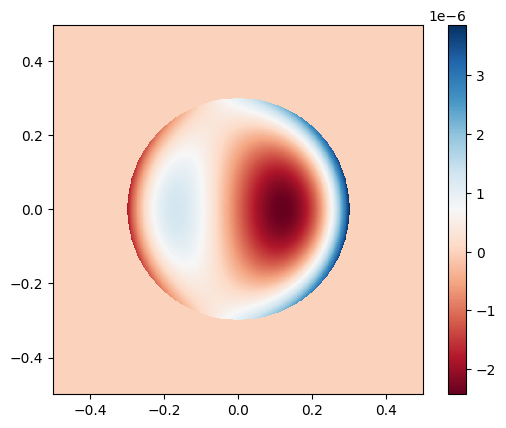

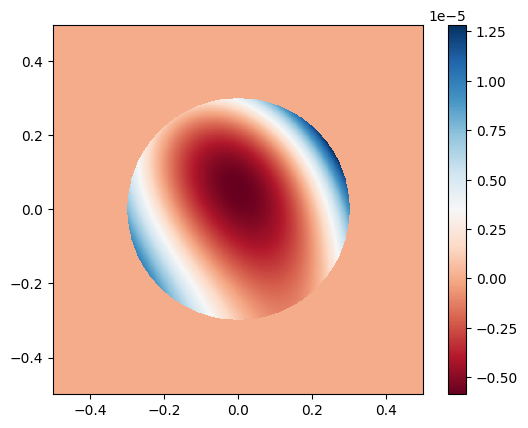

In [220]:

# imshow_field(aperture, cmap='RdBu')
# plt.colorbar()
# plt.show()

imshow_field(full_wf_atmo, cmap='RdBu')
plt.colorbar()
plt.show()

imshow_field(full_wf, cmap='RdBu')
plt.colorbar()
plt.show()


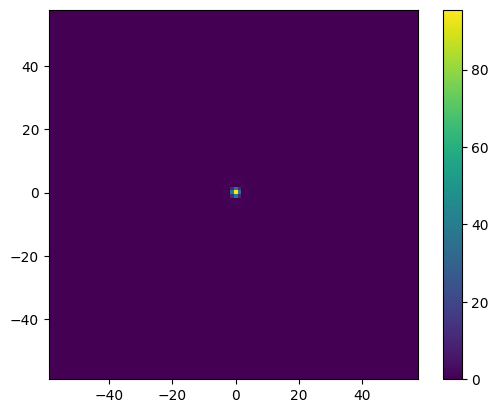

In [4]:
# AOI sensor focal plane
focal_grid = make_focal_grid_from_pupil_grid(pupil_grid, num_airy=50)
focal_grid = focal_grid.scaled(wavelength)

#The propagator.
prop = FraunhoferPropagator(aperture.grid, focal_grid, focal_length=1)
#Now we propagate it to the focal plane.
focal_wavefront_flat = prop.forward(pupil_wavefront_flat)

# focal_wavefront_flat.grid.weights = 1
#imshow_field(np.log10(focal_wavefront.intensity/focal_wavefront.intensity.max()), vmin=-1)
imshow_field(focal_wavefront_flat.power, vmin=0, grid_units=0.5e-6)
plt.colorbar()
plt.show()
# imshow_field(focal_wavefront.amplitude, vmin=0, grid_units=0.5e-6)
# plt.colorbar()
# plt.show()


6.103553379500138e+45


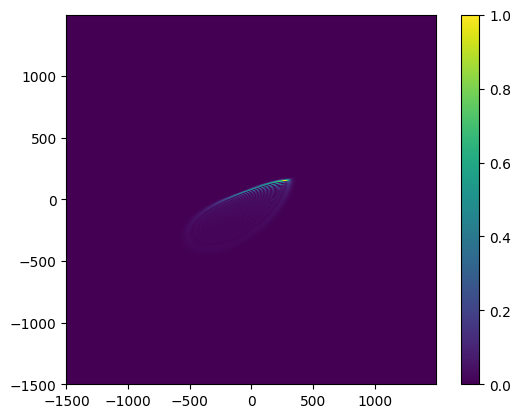

In [144]:
# Full sensor focal grid
focal_grid = make_focal_grid(q=1, num_airy=1500, spatial_resolution=1)
#focal_grid = make_focal_grid
# _from_pupil_grid(pupil_grid, q=1)
#Aperture function

#The propagator.
prop = FraunhoferPropagator(aperture.grid, focal_grid, focal_length=2)
#Now we propagate it to the focal plane.
focal_wavefront = prop.forward(pupil_wavefront)

imshow_field(focal_wavefront.intensity/focal_wavefront.intensity.max(), vmin=0)
#imshow_field(focal_wavefront.intensity/focal_wavefront.intensity.max())
plt.colorbar()
plt.show()


Resetting detector


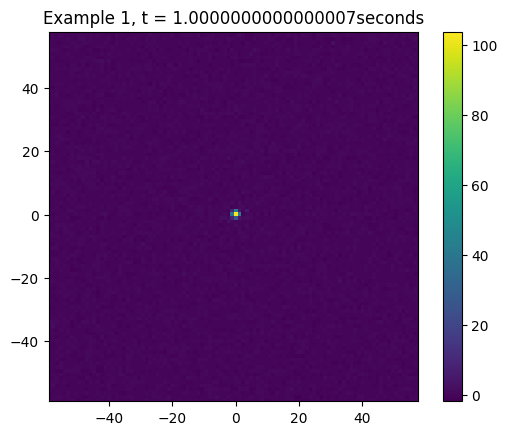

In [7]:
# Noise test
flatfield = 0 # 5% flat field error
darkcurrentrate = 0.00025 # electrons per second per pixel https://thinklucid.com/product/atlas-12-mp-imx253/
readnoise = 0.5 # rms electrons per read out, temporal dark noise https://thinklucid.com/product/atlas-12-mp-imx253/
photonnoise = True # Poisson noise

detector_example_1 = NoisyDetector(detector_grid=focal_grid, include_photon_noise=photonnoise, 
                                   flat_field=flatfield, dark_current_rate=darkcurrentrate, read_noise=readnoise)

T = 0
t = 0.001
for i in range(1000):
    T += 0.001
    detector_example_1.integrate(focal_wavefront_flat, t)

measurement = detector_example_1.read_out(final_frame=True)

plt.figure()
imshow_field(measurement,  grid_units=0.5e-6)
plt.colorbar()
plt.title('Example 1, t = ' + str(T) + 'seconds')

plt.show()

In [8]:
#Construct atmosphere
import pickle

d=0.6
r0 = 0.2 # 0.3
wavelength = 590e-9
L0 = 20  
velocity = 6.7 # m/s
stencil_length = 2
coeficients_flat = [0, 0, 0, 0, 0, 0, 0, 0] #flat wavefront.
seed = 11

# pupil_grid = make_pupil_grid(256, 1)
# focal_grid = make_focal_grid_from_pupil_grid(pupil_grid)
# aperture = make_circular_aperture(d)(pupil_grid)

# zern_flat = make_zernike_basis(8, d, pupil_grid, starting_mode=1, ansi=False, radial_cutoff=True, use_cache=True)
# full_wf_flat = zern_flat.linear_combination(coeficients_flat)
# pupil_wavefront_flat = Wavefront(np.exp(1j*((2*np.pi)/590e-9)*full_wf_flat)*aperture, wavelength=590e-9)
wf = pupil_wavefront_flat

mode_basis = make_zernike_basis(6, d, pupil_grid, 4)

# layers = []
# layer = InfiniteAtmosphericLayer(pupil_grid, Cn_squared_from_fried_parameter(r0, wavelength), L0, velocity, 0, stencil_length, seed=seed)
# layer2 = ModalAdaptiveOpticsLayer(layer, mode_basis, 1)
# layers.append(layer2)
# layer = InfiniteAtmosphericLayer(pupil_grid, Cn_squared_from_fried_parameter(r0, wavelength), L0, velocity, 0, stencil_length, seed=seed)
# layer3 = ModalAdaptiveOpticsLayer(layer, mode_basis, 1)
# layers.append(layer3)
# layer = InfiniteAtmosphericLayer(pupil_grid, Cn_squared_from_fried_parameter(r0, wavelength), L0, velocity, 0, stencil_length, seed=seed)
# layer4 = ModalAdaptiveOpticsLayer(layer, mode_basis, 1)
# layers.append(layer4)
layers = make_keck_atmospheric_layers(pupil_grid)
atmosphere = MultiLayerAtmosphere(layers, False)
# Save the atmosphere variable to a file
with open('atmosphere_modes.pkl', 'wb') as file:
    pickle.dump(atmosphere, file)
# atmosphere.Cn_squared = Cn_squared_from_fried_parameter(1/40, wavelength) # for setting the Cn_squared of all the atmosphere layers
# prop = FraunhoferPropagator(pupil_grid, focal_grid.scaled(wavelength))




Added layer at height 0m with Cn^2 = 3.69e-13 m^-2/3, L0 = 20m, and v = 6.7m/s
Added layer at height 2100m with Cn^2 = 2.19e-13 m^-2/3, L0 = 20m, and v = 13.9m/s
Added layer at height 4100m with Cn^2 = 1.27e-13 m^-2/3, L0 = 20m, and v = 20.8m/s
Added layer at height 6500m with Cn^2 = 1.01e-13 m^-2/3, L0 = 20m, and v = 29.0m/s
Added layer at height 9000m with Cn^2 = 4.6e-14 m^-2/3, L0 = 20m, and v = 29.0m/s
Added layer at height 12000m with Cn^2 = 1.11e-13 m^-2/3, L0 = 20m, and v = 29.0m/s
Added layer at height 14800m with Cn^2 = 2.7e-14 m^-2/3, L0 = 20m, and v = 29.0m/s


In [6]:
#atmo_test
t = 0.001
atmosphere.evolve_until(t)

wf2 = atmosphere.forward(wf)
wf2.electric_field *= aperture

# plt.figure()
# imshow_field(wf2.phase, cmap='RdBu')
# plt.colorbar()
# plt.draw()

wf3 = wf2.copy()
wf3.electric_field = wf3.electric_field * pupil_wavefront_flat.electric_field 

# plt.figure()
# imshow_field(wf3.phase, cmap='RdBu')
# plt.colorbar()
# plt.draw()

img = prop(wf3).intensity

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
im1 = imshow_field(wf2.phase, cmap='RdBu', ax=axs[0])  # Ensure to pass the correct axis
plt.colorbar(im1, ax=axs[0], shrink=0.7)
im2 = imshow_field(wf3.phase, cmap='RdBu', ax=axs[1])  # Ensure to pass the correct axis
plt.colorbar(im2, ax=axs[1], shrink=0.7)
im3 = imshow_field(np.log10(img / img.max()), vmin=-2, ax=axs[2])  # Ensure to pass the correct axis
plt.colorbar(im3, ax=axs[2], shrink=0.7)
# fig.set_title(f'Phase at t={t:.1f} seconds')
fig.suptitle(f'Phase at t={t:.1f} seconds', y=0.85)  # Adjust the value of y to bring the title closer to the figures


plt.draw()  # Update the figure
plt.show()


NameError: name 'atmosphere' is not defined

In [273]:
flatfield = 0 # 5% flat field error
darkcurrentrate = 0.00025 # electrons per second per pixel https://thinklucid.com/product/atlas-12-mp-imx253/
readnoise = 0.5 # rms electrons per read out, temporal dark noise https://thinklucid.com/product/atlas-12-mp-imx253/
photonnoise = True # Poisson noise
wf = pupil_wavefront_flat
frame_interval = 0.1 
atmosphere.reset()

detector = NoisyDetector(detector_grid=focal_grid, include_photon_noise=photonnoise, 
                                   flat_field=flatfield, dark_current_rate=darkcurrentrate, read_noise=readnoise)
t = 0.001
star_power = get_star_power()
frame_gen = Frame_Generator(detector, star_power, prop, strehl_ref)
atmo_phase, system_phase, psf, cost, strehl = frame_gen.generate_frame(t, wf, aperture, atmosphere,
                                                                  pupil_wavefront_flat, reset_time=0.001,
                                                                  integration_time=frame_interval)





Resetting detector
2193.763647618056 -0.0030140533224852044


In [117]:
# Load the atmosphere variable from the file
with open('atmosphere_modes.pkl', 'rb') as file:
    atmosphere = pickle.load(file)

In [148]:
# Atmosphere and focal plane variable sequence generator
num_frames = 10000 # Number of frames to generate
frame_interval = 0.001  # Time interval between frames
atmosphere_wavefront_history = []
focal_plane_history = []
atmosphere.reset()
wf = pupil_wavefront_flat
total_power = get_star_power()

# Generate atmospheric phase history and focal plane history
# now only saves the focal plane history
for frame in tqdm(range(num_frames), desc='Generating Frame Sequence'):
    t = frame * frame_interval
    atmosphere.evolve_until(t)
    wf2 = atmosphere.forward(wf)
    wf2.total_power = total_power
    # atmosphere_wavefront_history.append(wf2)
    focal_plane_history.append(prop(wf2).power)

# Save the atmosphere_wavefront_history and focal_plane_history variables to a file
with open('atmosphere_phase_history.pkl', 'wb') as file:
    pickle.dump(atmosphere_wavefront_history, file)
with open('focal_plane_aberrated_history.pkl', 'wb') as file:
    pickle.dump(focal_plane_history, file)

Generating Frame Sequence: 100%|██████████| 10000/10000 [6:10:58<00:00,  2.23s/it] 


In [149]:
# Split and save the data
# atmosphere_wavefront_history_1 = atmosphere_wavefront_history[0:1500]
# atmosphere_wavefront_history_2 = atmosphere_wavefront_history[1500:-1]
# focal_plane_history_1 = focal_plane_history[0:1500]
# focal_plane_history_2 = focal_plane_history[1500:-1]

# with open('atmosphere_phase_history_1.pkl', 'wb') as file:
#     pickle.dump(atmosphere_wavefront_history_1, file)
# with open('focal_plane_aberrated_history_1.pkl', 'wb') as file:
#     pickle.dump(focal_plane_history_1, file)
# with open('atmosphere_phase_history_2.pkl', 'wb') as file:
    # pickle.dump(atmosphere_wavefront_history_2, file)
with open('focal_plane_aberrated_history_10000.pkl', 'wb') as file:
    pickle.dump(focal_plane_history, file)

In [150]:
# Load the atmosphere_wavefront_history and focal_plane_history variables from the file and combine them
# with open('atmosphere_phase_history_1.pkl', 'rb') as file:
#     atmosphere_wavefront_history_1_l = pickle.load(file)
# with open('focal_plane_aberrated_history_1.pkl', 'rb') as file:
#     focal_plane_history_1_l = pickle.load(file)
# with open('atmosphere_phase_history_2.pkl', 'rb') as file:
#     atmosphere_wavefront_history_2_l = pickle.load(file)
with open('focal_plane_aberrated_history_10000.pkl', 'rb') as file:
    focal_plane_history_loaded = pickle.load(file)

# atmosphere_wavefront_history_loaded = atmosphere_wavefront_history_1_l + atmosphere_wavefront_history_2_l
# focal_plane_history_loaded = focal_plane_history_1_l + focal_plane_history_2_l

In [151]:
#Create a detectors and strehl reference frames

flatfield = 0 # 5% flat field error
darkcurrentrate = 0.00025 # electrons per second per pixel https://thinklucid.com/product/atlas-12-mp-imx253/
readnoise = 0.5 # rms electrons per read out, temporal dark noise https://thinklucid.com/product/atlas-12-mp-imx253/
photonnoise = True # Poisson noise

detector = NoisyDetector(detector_grid=focal_grid, include_photon_noise=photonnoise, 
                                   flat_field=flatfield, dark_current_rate=darkcurrentrate, read_noise=readnoise)

detector_perfect = NoisyDetector(detector_grid=focal_grid, include_photon_noise=False, 
                                 flat_field=0, dark_current_rate=0, read_noise=0) 

psf_ref = []

for i in tqdm(range(len(focal_plane_history_loaded)+1), desc='Strehl reference frame Generation'):
    detector_perfect.integrate(focal_wavefront_flat, dt=i/1000)
    psf_ref.append(detector_perfect.read_out(final_frame=False))


Strehl reference frame Generation: 100%|██████████| 10001/10001 [00:29<00:00, 342.07it/s]


Generating Frames:   0%|          | 0/999 [00:00<?, ?it/s]

Generating Frames: 100%|██████████| 999/999 [00:01<00:00, 563.09it/s]


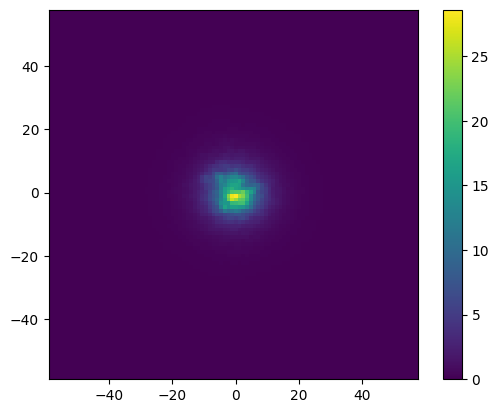

In [210]:
# Averaged single observation
frame_interval = 0.001  # Time interval between frames
num_frames = 999 # Number of frames to generate
for frame in tqdm(range(num_frames), desc='Generating Frames'):
    detector.integrate(focal_plane_history_loaded[frame], dt=frame_interval)

img = detector.read_out(final_frame=False)
imshow_field(img, vmin=0, grid_units=0.5e-6)
plt.colorbar()
plt.show()

In [173]:
# multiple average matrix
length = len(focal_plane_history_loaded)
multiples = np.arange(1, length+1, 100, dtype=int) # make it courser to speed up the process, increase each by 10
number_of_strides = ((length - multiples)/100).astype(int) # determines the confidence of variance
cost_matrix_0 = np.zeros((number_of_strides[0], multiples[-1]))
strehl_matrix_0 =  cost_matrix_0.copy()

frame_interval = 0.001  # Time interval between frames

In [174]:

for i in tqdm(range(len(multiples)), desc='Average Matrix Generation'):
    for k in range(number_of_strides[i]):
        for j in range(multiples[i]):
            # print(f'j: {j}, k: {k}, i: {i}, number_of_strides: {number_of_strides[i]}, multiples: {multiples[i]}')
            detector.integrate(focal_plane_history_loaded[j+k], dt=frame_interval*10)

        img_read = detector.read_out(final_frame=False)
        psf = img_read.copy()
        mat_size = int(np.sqrt(psf.shape[0]))
        img = psf.reshape(mat_size, mat_size).T
        cost_matrix_0[k, i], _, _ = cost(img, plot=False)
        strehl_matrix_0[k, i] = get_strehl_from_focal(psf, psf_ref[i])
       

Average Matrix Generation: 100%|██████████| 50/50 [1:21:04<00:00, 97.28s/it] 


In [175]:
# save the matrices of the average value strides
with open('cost_matrix_sample10000_multiples200_stride50.pkl', 'wb') as file:
    pickle.dump(cost_matrix_0, file)
with open('strehl_matrix_sample10000_multiples200_stride50.pkl', 'wb') as file:
    pickle.dump(strehl_matrix_0, file)

In [179]:
# load the stride matrices
with open('cost_matrix_100_4.pkl', 'rb') as file:
    cost_matrix_0 = pickle.load(file)
with open('strehl_matrix_100_4.pkl', 'rb') as file:
    strehl_matrix_0 = pickle.load(file)

In [180]:
ns = number_of_strides
n = multiples
N = ns + n + 1
num_pairs = (ns/2).astype(int)
dt = 0.001
cost_variance_sum = 0
strehl_variance_sum = 0
cost_variance = np.zeros(len(multiples))
strehl_variance = cost_variance.copy()
plotting_stride = np.linspace(dt, multiples[-1] * dt, len(multiples))


In [181]:

for i in tqdm(range(len(multiples)), desc = 'generating Allan variance'):
    for j in range(num_pairs[i]):
        cost_variance_sum += (cost_matrix_0[j+num_pairs[i], i] - cost_matrix_0[j, i])**2
        strehl_variance_sum += ((strehl_matrix_0[j+num_pairs[i], i] - strehl_matrix_0[j, i])**2)
    cost_variance[i] = (1 / (2 * num_pairs[i])) * cost_variance_sum
    strehl_variance[i] = (1 / (2 * num_pairs[i])) * strehl_variance_sum
    cost_variance_sum = 0
    strehl_variance_sum = 0


generating Allan variance:   0%|          | 0/50 [00:00<?, ?it/s]C:\Users\papuckaj\AppData\Local\Temp\ipykernel_7256\3691459062.py:4: RuntimeWarning: invalid value encountered in scalar subtract
  strehl_variance_sum += ((strehl_matrix_0[j+num_pairs[i], i] - strehl_matrix_0[j, i])**2)
C:\Users\papuckaj\AppData\Local\Temp\ipykernel_7256\3691459062.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  cost_variance[i] = (1 / (2 * num_pairs[i])) * cost_variance_sum
C:\Users\papuckaj\AppData\Local\Temp\ipykernel_7256\3691459062.py:5: RuntimeWarning: invalid value encountered in scalar multiply
  cost_variance[i] = (1 / (2 * num_pairs[i])) * cost_variance_sum
C:\Users\papuckaj\AppData\Local\Temp\ipykernel_7256\3691459062.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  strehl_variance[i] = (1 / (2 * num_pairs[i])) * strehl_variance_sum
C:\Users\papuckaj\AppData\Local\Temp\ipykernel_7256\3691459062.py:6: RuntimeWarning: invalid value encountered in scalar mul

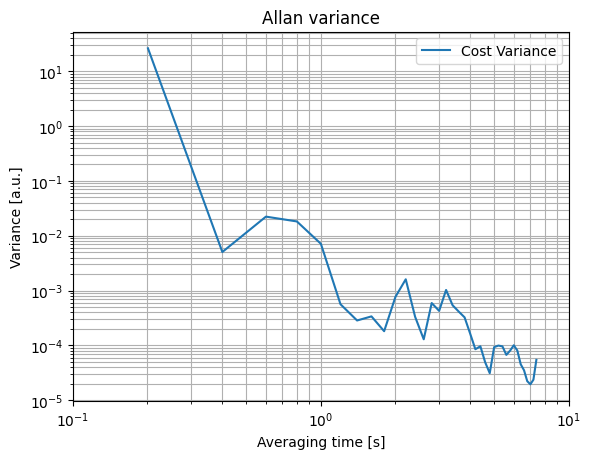

In [206]:

fig, ax = plt.subplots()
ax.plot(plotting_stride[1:38], cost_variance[1:38], label='Cost Variance')#, marker='o')
# ax.plot(plotting_stride[1:38], strehl_variance[1:38], label='Strehl Variance')#, marker='x')

# Setting the x-axis to logarithmic scale
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(0.1, 10)
ax.grid(True, which="both")
# Adding labels and title
ax.set_xlabel('Averaging time [s]')
ax.set_ylabel('Variance [a.u.]')
ax.set_title('Allan variance')
ax.legend()

plt.show()

In [43]:
# Parameters
num_frames = 10 # Number of frames to generate
frame_interval = 0.001  # Time interval between frames

wf = pupil_wavefront_flat

star_power = get_star_power()
frame_gen = Frame_Generator(detector, star_power, prop, strehl_ref)

# Path for saving frames
path_to_save = "frames/frame_{:03d}.png"

atmosphere.reset()
Strehl_history = []
Cost_history = []
# Create a video writer instance
with get_writer('output_video_keck_layers_with_noise.mp4', fps=1000) as writer:
    for frame in tqdm(range(num_frames), desc='Generating Frames'):  # tqdm wrapper around the loop
        
        t = frame * frame_interval
        atmo_phase, system_phase, psf, metric_val, strehl = frame_gen.generate_frame(t, wf, aperture, atmosphere,
                                                                  pupil_wavefront_flat, reset_time=10,
                                                                  integration_time=frame_interval*10)

        Strehl_history.append(strehl)
        Cost_history.append(metric_val)

        fig, axs = plt.subplots(1, 2, figsize=(10.08, 3.36))
        # Save the frame as an image
        im1 = imshow_field(atmo_phase, cmap='RdBu', ax=axs[0])  # Ensure to pass the correct axis
        plt.colorbar(im1, ax=axs[0], shrink=0.9)
        # im2 = imshow_field(system_phase, cmap='RdBu', ax=axs[1])  # Ensure to pass the correct axis
        # plt.colorbar(im2, ax=axs[1], shrink=0.7)
        im3 = imshow_field(psf, ax=axs[1], grid_units=0.5e-6)  # Ensure to pass the correct axis
        plt.colorbar(im3, ax=axs[1], shrink=0.9)
        fig.suptitle(f'Phase at t={t:.3f} seconds, Keck observatory, flat mirror', y=0.95)  # Adjust the value of y to bring the title closer to the figures
        plt.savefig(path_to_save.format(frame))
        plt.close(fig)
        fig.clear()
    
        # Add frame to video
        writer.append_data(plt.imread(path_to_save.format(frame)))

with open('Strehl_history_10000_1.pkl', 'wb') as file:
    pickle.dump(Strehl_history, file)
        
with open('Cost_history_10000_1.pkl', 'wb') as file:
    pickle.dump(Cost_history, file)



# Optionally, delete frames (this part can be handled in Python using os.remove)

Generating Frames:   0%|          | 0/10000 [00:00<?, ?it/s]

Resetting detector


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Generating Frames: 100%|██████████| 10000/10000 [8:02:38<00:00,  2.90s/it]


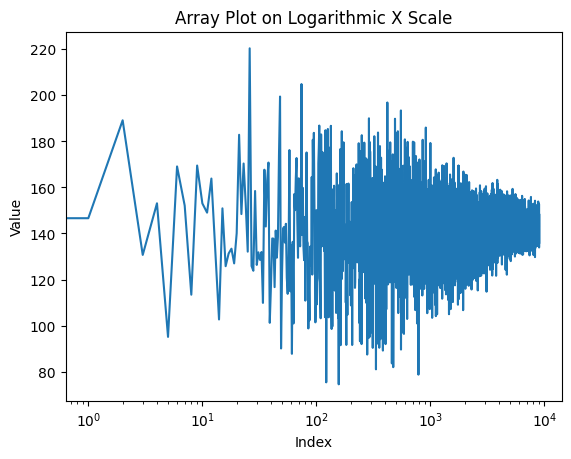

In [49]:

plt.semilogx(Cost_history[1000:9999])
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Array Plot on Logarithmic X Scale')
plt.show()
